In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# load pickle data
with open('ensemble.pickle', 'rb') as f:
    ensemble = pickle.load(f)

2022-08-26 14:31:35.311025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 14:31:35.339294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/serg/.mujoco/mujoco210/bin:/home/serg/.mujoco/mujoco210/bin
2022-08-26 14:31:35.339977: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-26 14:31:35.340408: I tensorflow/core/platform/cpu_feature_guar

In [3]:
NUMBER_OF_MODEL = 0 # 0 - 11
predicted = ensemble.get_predicted()
indexes_split = ensemble.stores[NUMBER_OF_MODEL].indexes_split
price_data = ensemble.stores[NUMBER_OF_MODEL].dataset


In [4]:
train_data = price_data[price_data.index.isin(indexes_split[0])]
test_data = price_data[price_data.index.isin(indexes_split[1])]
print(len(train_data), len(test_data), len(predicted.get(f'LSTM_regressor_{NUMBER_OF_MODEL}')))

436 188 188


In [7]:
import plotly.graph_objects as go
predicted_0 = pd.DataFrame(predicted[f'LSTM_regressor_{NUMBER_OF_MODEL}'], columns=test_data.columns)
predicted_0['date'] = test_data.index

fig = go.Figure(data=[go.Candlestick(
                x=predicted_0['date'],
                open=predicted_0['open'],
                high=predicted_0['high'],
                low=predicted_0['low'],
                close=predicted_0['close'])])
fig_real = go.Figure(data=[go.Candlestick(
                x=test_data.index,
                open=test_data['open'],
                high=test_data['high'],
                low=test_data['low'],
                close=test_data['close'])])

fig.show()
fig_real.show()

In [8]:

TIME_POINT = 20
predicted_total = [predicted[f'LSTM_regressor_{i}'] for i in range(12)]
predicted_series = pd.DataFrame([i[TIME_POINT] for i in predicted_total], columns=test_data.columns)
fig = go.Figure(data=[go.Candlestick(
                x=predicted_series.index,
                open=predicted_series['open'],
                high=predicted_series['high'],
                low=predicted_series['low'],
                close=predicted_series['close'])])
fig.show()

actual_data = pd.DataFrame(test_data.values[TIME_POINT:TIME_POINT+12], columns=test_data.columns)
fig = go.Figure(data=[go.Candlestick(
                x=actual_data.index,
                open=actual_data['open'],
                high=actual_data['high'],
                low=actual_data['low'],
                close=actual_data['close'])])
fig.show()

In [53]:
# Backtest the models
from tabnanny import verbose


trading_data = test_data.copy().reset_index()
cols = test_data.columns
trading_data['signal'] = 0 
for i, v in trading_data.iterrows():
    if i < 12:
        continue
    # take last 12 rows
    actual_data = trading_data.iloc[i-12:i][cols]
    for j in range(12):
        scaler = ensemble.stores[j].transformer
        model = ensemble.stores[j].model
        
        data = scaler.scaler.transform(actual_data.values)
        predicted = model.predict(data.reshape(-1, 12, len(cols)))
        expected_price = scaler.inverse_min_max_scaler(predicted)
        open_price = actual_data['open'].values[0]
        min_price = expected_price[0][2]
        min_prcie_percentage = (open_price - min_price) / open_price
        max_price = expected_price[0][1]
        max_prcie_percentage = (open_price - max_price) / open_price
        range_price = max_price - min_price
        volatility = range_price / open_price
        last_price = actual_data.iloc[-1]['close']
    if max_prcie_percentage > 0:
        trading_data.loc[i, 'signal'] = -1
    if min_prcie_percentage < 0:
        trading_data.loc[i, 'signal'] = 1
    break
    


1/1 [==============================] - 0s 13ms/step


23286.332

In [10]:
# create target column
columns = []
for i in range(1, 13):
    name = f'target_{i}'
    columns.append(name)
    trading_data[name] = trading_data['close'].pct_change(i).shift(-i) * trading_data['signal']

In [14]:
trading_data.groupby('signal')[columns].agg(['mean', 'std', 'sum', 'count']).T

signal               0          1
target_1  mean     0.0  -0.004351
          std      0.0   0.010454
          sum      0.0  -0.065262
          count  172.0  15.000000
target_2  mean     0.0  -0.008931
          std      0.0   0.013345
          sum      0.0  -0.133972
          count  171.0  15.000000
target_3  mean     0.0  -0.011470
          std      0.0   0.013852
          sum      0.0  -0.172052
          count  170.0  15.000000
target_4  mean     0.0  -0.014316
          std      0.0   0.014681
          sum      0.0  -0.214733
          count  169.0  15.000000
target_5  mean     0.0  -0.017216
          std      0.0   0.015737
          sum      0.0  -0.258238
          count  168.0  15.000000
target_6  mean     0.0  -0.019523
          std      0.0   0.017022
          sum      0.0  -0.292844
          count  167.0  15.000000
target_7  mean     0.0  -0.021431
          std      0.0   0.016497
          sum      0.0  -0.321467
          count  166.0  15.000000
target_8  mean     0.0  -0.022469
          std      0.0   0.015955
          sum      0.0  -0.337028
          count  165.0  15.000000
target_9  mean     0.0  -0.023662
          std      0.0   0.016519
          sum      0.0  -0.354924
          count  164.0  15.000000
target_10 mean     0.0  -0.024166
          std      0.0   0.016034
          sum      0.0  -0.362487
          count  163.0  15.000000
target_11 mean     0.0  -0.024814
          std      0.0   0.014405
          sum      0.0  -0.372216
          count  162.0  15.000000
target_12 mean     0.0  -0.025192
          std      0.0   0.015271
          sum      0.0  -0.377873
          count  161.0  15.000000

<AxesSubplot:>

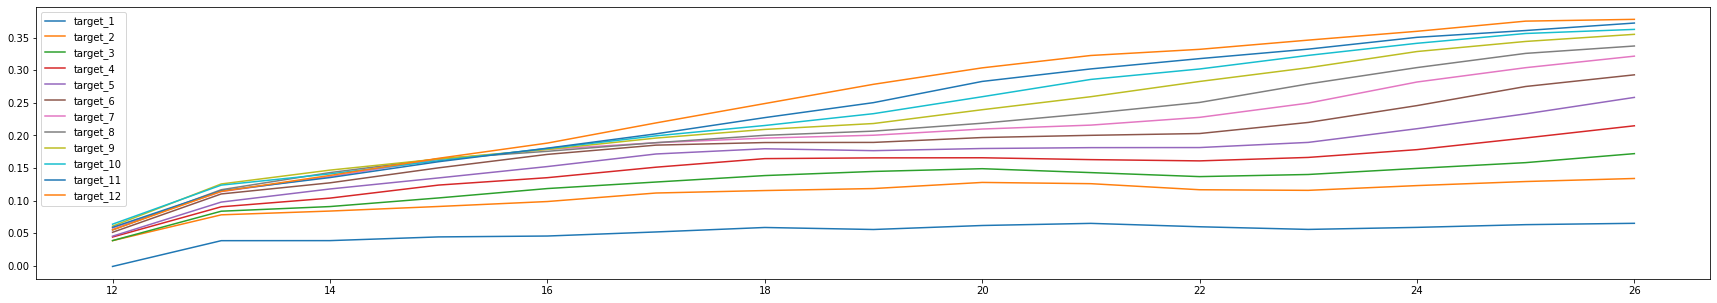

In [12]:
trading_data[trading_data['signal'] == 1][columns].cumsum().divide(-1).plot(figsize=(30, 5))